In [5]:
import numpy as np
import pandas as pd

import re
import json

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

In [6]:
import seaborn as sns

In [7]:
import matplotlib.pyplot as plt

In [8]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [9]:
data = pd.read_json(r"../data/news_headlines/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [10]:
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [11]:
data = data.rename(columns = {"is_sarcastic":"Sarcasm","headline":"Headline"})

In [12]:
data = data.drop("article_link",axis=1)
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sarcasm   28619 non-null  int64 
 1   Headline  28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [14]:
data.isnull().sum()

Sarcasm     0
Headline    0
dtype: int64

In [15]:
data["Sarcasm"].value_counts()

0    14985
1    13634
Name: Sarcasm, dtype: int64

<AxesSubplot:title={'center':'Non-Sarcastic vs. Sarcastic'}, xlabel='Sarcasm', ylabel='count'>

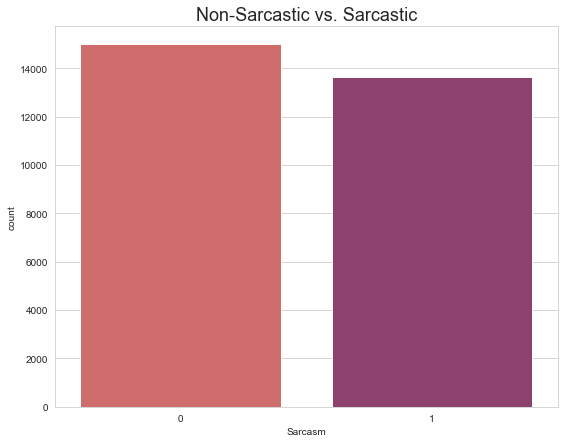

In [16]:
sns.set_style("whitegrid")

plt.figure(figsize = (9,7))

plt.title("Non-Sarcastic vs. Sarcastic", fontsize=18)
sns.countplot(x="Sarcasm",data=data, palette="flare")

In [17]:
data.duplicated(subset=["Headline"]).value_counts()

False    28503
True       116
dtype: int64

In [18]:
dupes = data[data.duplicated(subset=["Headline"])==True]
dupes.head()

,Sarcasm,Headline
1780,1,willow rented
3978,1,all y'all urged to go fuck yo' selves
4771,0,sunday roundup
4904,1,tammys of the world demand to be taken seriously
5092,0,the funniest tweets from parents this week


In [19]:
data = data.drop_duplicates(subset=["Headline"])

In [20]:
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [21]:
data[data["Headline"].str.contains("-")].head()

,Sarcasm,Headline
7,1,richard branson's global-warming donation near...
16,1,area boy enters jumping-and-touching-tops-of-d...
19,0,lin-manuel miranda would like to remind you to...
34,1,new york introduces shoe-sharing program for c...
40,0,the best clothes for the man-child in your life


In [22]:
data[data["Headline"].str.contains("/")].head()

,Sarcasm,Headline
384,0,if i have gay children: 4 promises from a chri...
821,1,google's 9/11 homepage design stirs controversy
1169,1,encouraging report from radical extremist thin...
1209,0,this is what it was like to go to the airport ...
1413,0,barack obama makes last-minute push to block s...


In [23]:
def clean_text(text):
    text = text.lower()
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    
    return text

In [24]:
headlines = data["Headline"].values.tolist()

In [25]:
clean_text(headlines[24])

'bill clinton shoots down republicans i strongly supported obamacare'

In [26]:
cleaned = []
for string in headlines:
    string = clean_text(string)
    cleaned.append(string) 

In [27]:
data["Headline"] = cleaned
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


In [28]:
data_cloud = data.copy()

In [29]:
sarcasm = data_cloud[data_cloud["Sarcasm"] == 1]

In [30]:
normal = data_cloud[data_cloud["Sarcasm"] == 0]

In [31]:
stopwords = set(STOPWORDS)

In [32]:
text1 = " ".join(line for line in sarcasm["Headline"])

In [35]:
text2 = " ".join(line for line in normal["Headline"])

In [2]:
sarcasm = list(data["Sarcasm"].values)
headlines = list(data["Headline"].values)

NameError: name 'data' is not defined

In [ ]:
vocab_size = 7500
embedding_dim = 16
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
training_size = 23000

In [ ]:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]

training_sarcasm = sarcasm[0:training_size]
testing_sarcasm = sarcasm[training_size:]

In [ ]:
training_headlines

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
training_padded = np.array(training_padded)
training_sarcasm = np.array(training_sarcasm)
testing_padded = np.array(testing_padded)
testing_sarcasm = np.array(testing_sarcasm)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(Flatten())

model1.add(Dense(units=32,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=10,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
vocab_lenght = ((len(word_index)) + 1)

In [ ]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim=24846,
    output_dim=64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(model6.summary())

In [ ]:
model.summary()

In [ ]:
model1.summary()